## Set up Workspace

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate, stats
import xesmf as xe
from datetime import datetime, timedelta
from ngallery_utils import DATASETS

%matplotlib inline

var = 'uas'

## Look at Data

In [2]:
hist_file = DATASETS.fetch("uas.hist.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.Colorado.nc")
rcp85_file = DATASETS.fetch("uas.rcp85.CanESM2.CRCM5-UQAM.day.NAM-44i.raw.Colorado.nc")
meas_file = DATASETS.fetch("uas.gridMET.NAM-44i.Colorado.nc")

In [3]:
ds_hist = xr.open_dataset(hist_file)
ds_hist

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 8, lon: 16, time: 20440)
Coordinates:
  * time       (time) object 1950-01-01 12:00:00 ... 2005-12-31 12:00:00
  * lat        (lat) float64 37.25 37.75 38.25 38.75 39.25 39.75 40.25 40.75
  * lon        (lon) float64 -109.8 -109.2 -108.8 ... -103.2 -102.8 -102.2
Dimensions without coordinates: bnds
Data variables:
    uas        (time, lat, lon) float32 ...
    time_bnds  (time, bnds) object ...
Attributes:
    Conventions:                    CF-1.4
    institution:                    Universite du Quebec a Montreal
    contact:                        Winger.Katja@uqam.ca
    comment:                        CORDEX North America CRCM5 v333 0.44 deg ...
    model:                          CRCM5 (dynamics GEM v_3.3.3, physics RPN ...
    model_grid:                     rotated lat-lon 236x241 incl. 10p pilot a...
    geophysical_fields:             orography: USGS / land use cover: USGS / ...
    physics:                        land: CLASS3.5

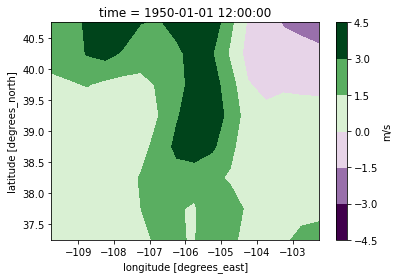

In [4]:
ds_hist[var].isel(time=0).plot.contourf(x="lon", y="lat", cmap="PRGn", cbar_kwargs={"label": "m/s"})

In [5]:
ds_rcp85 = xr.open_dataset(rcp85_file)
ds_rcp85

<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 8, lon: 16, time: 20440)
Coordinates:
  * time       (time) object 1950-01-01 12:00:00 ... 2005-12-31 12:00:00
  * lat        (lat) float64 37.25 37.75 38.25 38.75 39.25 39.75 40.25 40.75
  * lon        (lon) float64 -109.8 -109.2 -108.8 ... -103.2 -102.8 -102.2
Dimensions without coordinates: bnds
Data variables:
    uas        (time, lat, lon) float32 ...
    time_bnds  (time, bnds) object ...
Attributes:
    Conventions:                    CF-1.4
    institution:                    Universite du Quebec a Montreal
    contact:                        Winger.Katja@uqam.ca
    comment:                        CORDEX North America CRCM5 v333 0.44 deg ...
    model:                          CRCM5 (dynamics GEM v_3.3.3, physics RPN ...
    model_grid:                     rotated lat-lon 236x241 incl. 10p pilot a...
    geophysical_fields:             orography: USGS / land use cover: USGS / ...
    physics:                        land: CLASS3.5

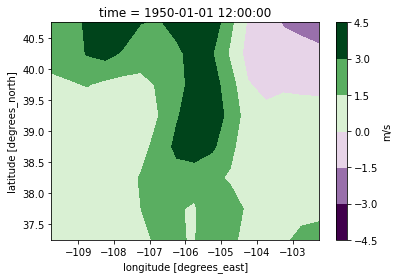

In [6]:
ds_rcp85[var].isel(time=0).plot.contourf(x="lon", y="lat", cmap="PRGn", cbar_kwargs={"label": "m/s"})

In [7]:
ds_meas = xr.open_dataset(meas_file)
ds_meas

<xarray.Dataset>
Dimensions:      (bnds: 2, lat: 8, lon: 16, time: 13880)
Coordinates:
  * time         (time) datetime64[ns] 1979-01-01T19:00:00 ... 2016-12-31T19:00:00
  * lon          (lon) float64 -109.8 -109.2 -108.8 ... -103.2 -102.8 -102.2
  * lat          (lat) float64 37.25 37.75 38.25 38.75 39.25 39.75 40.25 40.75
Dimensions without coordinates: bnds
Data variables:
    uas          (time, lat, lon) float32 ...
    time_bnds    (time, bnds) datetime64[ns] ...
    data_status  (time) int8 ...
    lon_bnds     (lon, bnds) float32 ...
    lat_bnds     (lat, bnds) float32 ...
    crs          int32 ...
Attributes:
    author:                    John Abatzoglou - University of Idaho, jabatzo...
    creation_date:             10 March 2016
    Conventions:               CF-1.6
    title:                     gridMET gridded surface meteorological data
    institution:               University of Idaho
    contact:                   John Abatzoglou, jabatzoglou@uidaho.edu
    URL:   

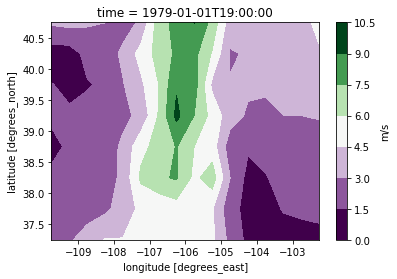

In [8]:
ds_meas[var].isel(time=0).plot.contourf(x="lon", y="lat", cmap="PRGn", cbar_kwargs={"label": "m/s"})

## Align Time

In [9]:
ds_meas_noleap = ds_meas.sel(time=~((ds_meas.time.dt.dayofyear == 366) ))

In [10]:
def _cfnoleap_to_datetime(da):
    datetimeindex = da.indexes['time'].to_datetimeindex()
    ds = da#.to_dataset()
    ds['time_dt']= ('time', datetimeindex)
    ds = ds.swap_dims({'time': 'time_dt'})
    assert len(da.time) == len(ds.time_dt)
    return ds

ds_hist_dt = _cfnoleap_to_datetime(ds_hist)   
ds_rcp85_dt = _cfnoleap_to_datetime(ds_rcp85)  

/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  


In [11]:
def _regroup_models_bytime(ds_meas, ds_hist_dt, ds_rcp_dt):
    t0_meas = ds_meas.time[0]
    tn_meas = ds_meas.time[-1]
    t0_fut = tn_meas.values + np.timedelta64(1, 'D')
    
    ds_past = ds_hist_dt.sel(time_dt = slice(t0_meas, tn_meas))
    ds_past = ds_past.swap_dims({'time_dt':'time'})
    
    ds_fut_pt1 = ds_hist_dt.sel(time_dt = slice(t0_fut,None))
    ds_fut = xr.concat([ds_fut_pt1[var], ds_rcp_dt[var]], 'time_dt')
    ds_fut = ds_fut.swap_dims({'time_dt':'time'})
    return ds_past, ds_fut

ds_past, ds_fut = _regroup_models_bytime(ds_meas_noleap, ds_hist_dt, ds_rcp85_dt)

## Bias Correction
  
- Bias correction methods other than zscore:
    - scale (for wind speed, wave flux in air)
    - log (for precipitation)
    - range (relative humidity)
    - seth mcginnes's kddm (for any bimodal distributions)

In [12]:
def _reshape(ds, window_width):
    split = lambda g: (g.rename({'time': 'day'})
                       .assign_coords(day=g.time.dt.dayofyear.values))
    ds2 = ds.groupby('time.year').apply(split)
    
    early_Jans = ds2.isel(day = slice(None,window_width//2))
    late_Decs = ds2.isel(day = slice(-window_width//2,None))
    
    ds3 = xr.concat([late_Decs,ds2,early_Jans],dim='day')
    return ds3

def _calc_stats(ds, window_width):
    ds_rsh = _reshape(ds, window_width)
    
    ds_rolled = ds_rsh.rolling(day=window_width, center=True).construct('win_day')
    
    n = window_width//2+1
    ds_mean = ds_rolled.mean(dim=['year','win_day']).isel(day=slice(n,-n))
    ds_std = ds_rolled.std(dim=['year','win_day']).isel(day=slice(n,-n))
    
    ds_avyear = ds_rsh.mean(dim=['year','day'])
    ds_zscore = ((ds_avyear - ds_mean) / ds_std)
    return ds_mean, ds_std, ds_zscore

window_width=31
meas_mean, meas_std, meas_zscore = _calc_stats(ds_meas_noleap, window_width)
hist_mean, hist_std, hist_zscore = _calc_stats(ds_past, window_width)

In [13]:
def _get_params(meas_mean, meas_std, past_mean, past_std):    
    shift = meas_mean - past_mean
    scale = meas_std / past_std
    return shift, scale

shift, scale = _get_params(meas_mean, meas_std, hist_mean, hist_std)

In [14]:
def _calc_fut_stats(ds_fut, window_width):
    ds_rolled = ds_fut.rolling(time=window_width, center=True).construct('win_day')
    
    ds_mean = ds_rolled.mean(dim=['win_day'])
    ds_std = ds_rolled.std(dim=['win_day'])
    
    ds_avyear = ds_fut.mean(dim=['time'])
    ds_zscore = ((ds_avyear - ds_mean) / ds_std)
    return ds_mean, ds_std, ds_zscore

fut_mean, fut_std, fut_zscore = _calc_fut_stats(ds_fut, window_width)

In [15]:
fut_mean_bc = fut_mean + shift
fut_std_bc = fut_std * scale

fut_corrected = (fut_zscore * fut_std_bc) + fut_mean_bc

# Visualize the Correction

In [18]:
def gaus(mean, std, doy):
    a = mean.sel(day=doy)
    mu = a.isel(lon = 5, lat = 5)

    b =std.sel(day=doy)
    sigma = b.isel(lon = 5, lat = 5)

    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    y = stats.norm.pdf(x, mu, sigma)
    return x, y

/ncar/usr/jupyterhub/envs/cmip6-201910/lib/python3.7/site-packages/xarray/core/groupby.py:635: FutureWarning: This DataArray contains multi-dimensional coordinates. In the future, these coordinates will be transposed as well unless you specify transpose_coords=False.
  return stacked.transpose(*new_order, transpose_coords=self._restore_coord_dims)


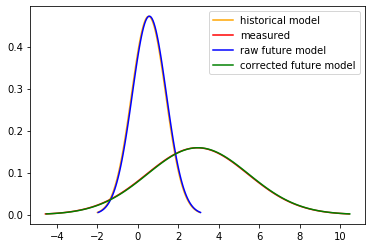

In [21]:
fut_typ_mean, fut_typ_std, fut_typ_zscore = _calc_stats(ds_fut, window_width)
fut_typ_mean_bc = fut_typ_mean + shift
fut_typ_std_bc = fut_typ_std * scale

doy=20
plt.figure()
x,y = gaus(hist_mean[var], hist_std[var], doy)
plt.plot(x, y, 'orange', label = 'historical model')
x,y = gaus(meas_mean[var], meas_std[var], doy)
plt.plot(x, y, 'red', label = 'measured')
x,y = gaus(fut_typ_mean, fut_typ_std, doy)
plt.plot(x, y, 'blue', label = 'raw future model')
x,y = gaus(fut_typ_mean_bc[var], fut_typ_std_bc[var], doy)
plt.plot(x, y, 'green', label = 'corrected future model')
plt.legend()